In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tabulate import tabulate
from matplotlib.colors import LogNorm
import textwrap
from collections import Counter
import re



# Specify the file path
file_path = r"cleaned_target_drugs.csv"
data_dictionary = r"faers_analysis_dataset_dictionary.xlsx"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)
df_dictionary = pd.read_excel(data_dictionary, sheet_name=None)
for sheet_name, drug in df_dictionary.items():
    # Perform your processing here
    print(f"Sheet name: {sheet_name}")

#Get the sheet named Psychiatric Disorder Reac Grp from df_dictionary
df_faers_data_dictionary = df_dictionary['faers_2004_2024q1_dictionary']
df_target_drugs = df_dictionary['Target Drugs']
df_psychiatric = df_dictionary['Psychiatric Disorder Reac Grp']


Sheet name: faers_2004_2024q1_dictionary
Sheet name: Target Drugs
Sheet name: Psychiatric Disorder Reac Grp


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tabulate import tabulate
from matplotlib.colors import LogNorm
import textwrap
from collections import Counter
import re



# Specify the file path
file_path = r"cleaned_target_drugs.csv"
data_dictionary = r"faers_analysis_dataset_dictionary.xlsx"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)
df_dictionary = pd.read_excel(data_dictionary, sheet_name=None)
for sheet_name, drug in df_dictionary.items():
    # Perform your processing here
    print(f"Sheet name: {sheet_name}")

#Get the sheet named Psychiatric Disorder Reac Grp from df_dictionary
df_faers_data_dictionary = df_dictionary['faers_2004_2024q1_dictionary']
df_target_drugs = df_dictionary['Target Drugs']
df_psychiatric = df_dictionary['Psychiatric Disorder Reac Grp']


Sheet name: faers_2004_2024q1_dictionary
Sheet name: Target Drugs
Sheet name: Psychiatric Disorder Reac Grp


In [6]:
# Display the frequency of each drug
print(df['ps_drugname'].value_counts())

# antihistamine_drugs = ['zyrtec', 'claritin', 'allegra', 'xyzal']
# leukotriene_drugs = ['singulair', 'accolate', 'zyflo']

# Example: Selecting the most common drug as the reference
# reference_drug = df_filtered['ps_drugname'].mode()[0]
reference_drug = 'allergy_medication_SINGULAIR'
print(f"Selected Reference Category: {reference_drug}")


singulair                                                  14536
zyrtec                                                     13144
claritin                                                   11719
allegra                                                     9027
xyzal                                                       2430
                                                           ...  
efavirenz,lamivudine,tenofovir mylan                           1
tremfya                                                        1
buspirone                                                      1
paclitaxel 6mg/ml concentrate for solution for infusion        1
wegovy                                                         1
Name: ps_drugname, Length: 1878, dtype: int64
Selected Reference Category: allergy_medication_SINGULAIR


Results:
LogisticRegression(max_iter=1000, random_state=42)

Model Performance (Logistic Regression):
Accuracy: 0.749
ROC AUC: 0.835
F1 Score: 0.742

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76     12401
           1       0.76      0.72      0.74     12284

    accuracy                           0.75     24685
   macro avg       0.75      0.75      0.75     24685
weighted avg       0.75      0.75      0.75     24685



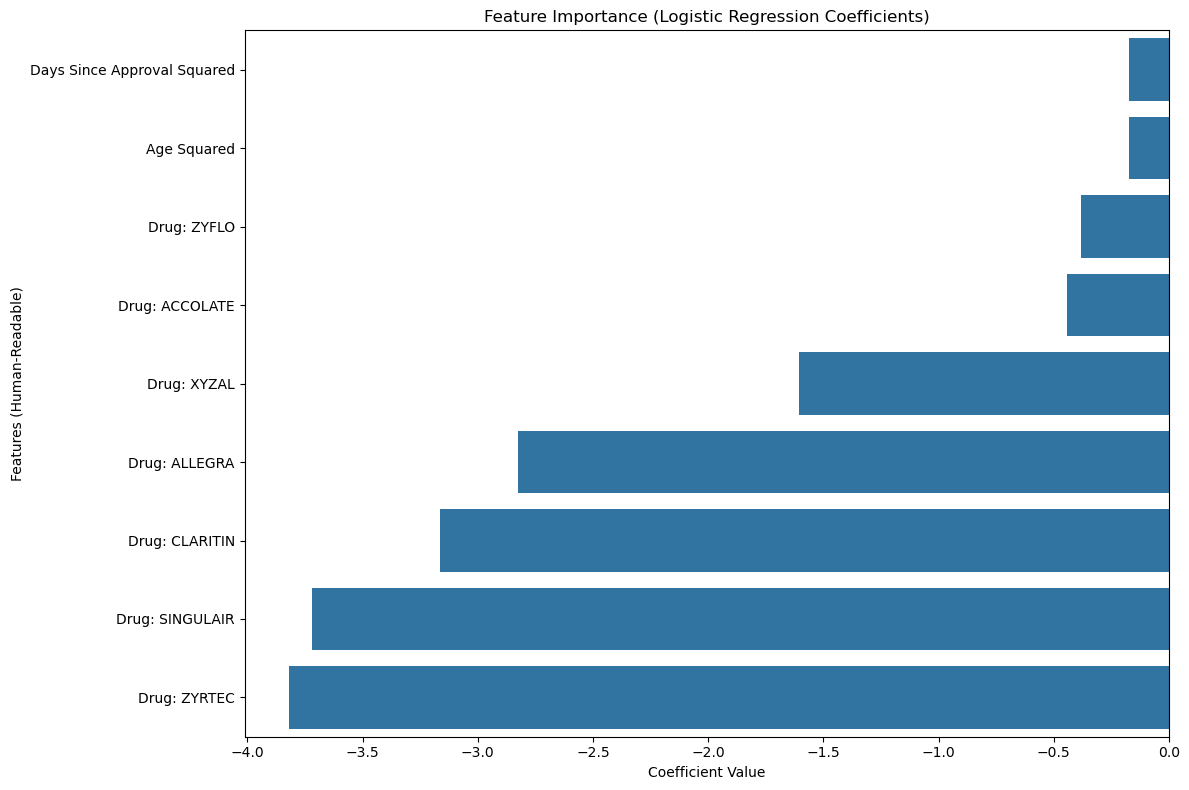

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------
# 1. Data Preprocessing and Feature Engineering
# --------------------------------------------

# Assuming df, df_psychiatric, and df_target_drugs are predefined DataFrames

# Convert relevant text columns to uppercase for consistency
dfc = df.copy()
dfc['reaction_pt'] = df['reaction_pt'].str.upper()
dfc['ps_drugname'] = df['ps_drugname'].str.upper()

# Define psychiatric reactions
psychiatric_reactions = df_psychiatric['Reaction'].str.upper().tolist()

# Create binary target variable
dfc['psychiatric_adverse_reaction'] = dfc['reaction_pt'].isin(psychiatric_reactions).astype(int)

# Define categorical variable based on the drug name
dfc['allergy_medication'] = df['allergy_medication'].str.upper()

# Define continuous variables
continuous_features = ['age', 'days_since_approval']
dfc_continuous = dfc[continuous_features]

# Combine categorical and continuous features
X = pd.get_dummies(dfc[['allergy_medication']])
X = pd.concat([X, dfc_continuous], axis=1)
y = dfc['psychiatric_adverse_reaction']

# Handle missing values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

# Add polynomial features for continuous variables (retain squared terms only for nonlinearity)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X[continuous_features]), columns=poly.get_feature_names_out(continuous_features))
X_poly = X_poly[['age^2', 'days_since_approval^2']]  # Retain only squared terms
X = pd.concat([X.drop(columns=continuous_features), X_poly], axis=1)

# --------------------------------------------
# 2. Addressing Class Imbalance
# --------------------------------------------

# Apply ADASYN for class balancing
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# --------------------------------------------
# 3. Feature Scaling
# --------------------------------------------

scaler = StandardScaler()
X_resampled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X.columns)

# --------------------------------------------
# 4. Train-Test Split
# --------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --------------------------------------------
# 5. Logistic Regression with Cross-Validation
# --------------------------------------------

# Train logistic regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)

print("Results:")
# Print the result of logistic regression
print(log_reg.fit(X_train, y_train))

print("\nModel Performance (Logistic Regression):")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"F1 Score: {f1:.3f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --------------------------------------------
# 6. Visualization of Feature Importance
# --------------------------------------------

# Visualization of Feature Importance

# Get feature coefficients from Logistic Regression
feature_coefficients = pd.Series(log_reg.coef_[0], index=X_resampled.columns).sort_values(ascending=False)

# Rename features to be more human-readable
feature_coefficients.index = feature_coefficients.index.str.replace('allergy_medication_', 'Drug: ', regex=False)
feature_coefficients.index = feature_coefficients.index.str.replace('age^2', 'Age Squared', regex=False)
feature_coefficients.index = feature_coefficients.index.str.replace('days_since_approval^2', 'Days Since Approval Squared', regex=False)
feature_coefficients.index = feature_coefficients.index.str.replace('_interaction', ' Interaction', regex=False)

# Plot all features including days_since_approval^2 and age^2 with readable axis names
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_coefficients.values, y=feature_coefficients.index)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features (Human-Readable)")
plt.tight_layout()
plt.show()



In [21]:
from scipy.stats import norm
import numpy as np
import pandas as pd

# Step 1: Fit the logistic regression model (already done)
# Coefficients and intercept
coefficients = log_reg.coef_[0]
intercept = log_reg.intercept_[0]

# Step 2: Compute the covariance matrix
# Adding intercept for consistent matrix dimensions
X_train_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
cov_matrix = np.linalg.inv(np.dot(X_train_design.T, X_train_design))

# Extract standard errors
standard_errors = np.sqrt(np.diag(cov_matrix)[1:])  # Skip intercept term

# Step 3: Calculate Z-Scores
z_scores = coefficients / standard_errors

# Step 4: Calculate P-Values
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))  # Two-tailed test

# Combine results into a DataFrame
p_value_df = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Coefficient': coefficients,
    'Standard Error': standard_errors,
    'Z-Score': z_scores,
    'P-Value': p_values
}).sort_values(by='P-Value')

# Format p-values in scientific notation
p_value_df['P-Value'] = p_value_df['P-Value'].apply(lambda x: "<= 1e-308" if x == 0.0 else f"{x:.10e}")

# Display the DataFrame with P-Values for Logistic Regression Coefficients
print("P-Values for Logistic Regression Coefficients:")
print(p_value_df.to_string(index=False))


P-Values for Logistic Regression Coefficients:
                     Feature  Coefficient  Standard Error     Z-Score   P-Value
 allergy_medication_ACCOLATE    -0.443150        0.003155 -140.479224 <= 1e-308
  allergy_medication_ALLEGRA    -2.827578        0.003932 -719.098718 <= 1e-308
 allergy_medication_CLARITIN    -3.164925        0.004089 -773.971635 <= 1e-308
allergy_medication_SINGULAIR    -3.718892        0.004328 -859.198182 <= 1e-308
    allergy_medication_XYZAL    -1.605678        0.003439 -466.847803 <= 1e-308
    allergy_medication_ZYFLO    -0.381638        0.003181 -119.973020 <= 1e-308
   allergy_medication_ZYRTEC    -3.821456        0.004073 -938.192783 <= 1e-308
                       age^2    -0.173833        0.003399  -51.138452 <= 1e-308
       days_since_approval^2    -0.172623        0.003643  -47.382237 <= 1e-308


In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for the resampled feature set
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for resampled features
vif_resampled = calculate_vif(X_resampled)

# Display VIF values
print("\nVariance Inflation Factor (VIF):")
print(vif_resampled)



Variance Inflation Factor (VIF):
                        Feature       VIF
0   allergy_medication_ACCOLATE  1.010668
1    allergy_medication_ALLEGRA  1.525594
2   allergy_medication_CLARITIN  1.649385
3  allergy_medication_SINGULAIR  1.842280
4      allergy_medication_XYZAL  1.168431
5      allergy_medication_ZYFLO  1.002855
6     allergy_medication_ZYRTEC  1.628346
7                         age^2  1.140430
8         days_since_approval^2  1.307731


In [9]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for Logistic Regression
log_reg_cv_scores = cross_val_score(log_reg, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(f"\nLogistic Regression Cross-Validation Scores (ROC AUC): {log_reg_cv_scores}")
print(f"Mean ROC AUC: {log_reg_cv_scores.mean():.3f}")



Logistic Regression Cross-Validation Scores (ROC AUC): [0.76149078 0.8911483  0.69113957 0.60327633 0.82805685]
Mean ROC AUC: 0.755


/var/folders/vn/g0wlzfbn7_n6wh0xn1kwxsgr0000gn/T/ipykernel_46718/3442488201.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


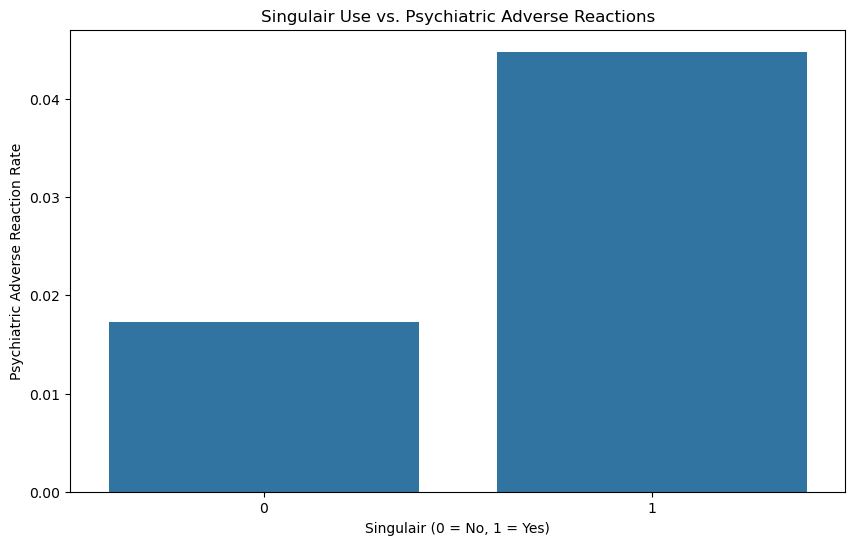

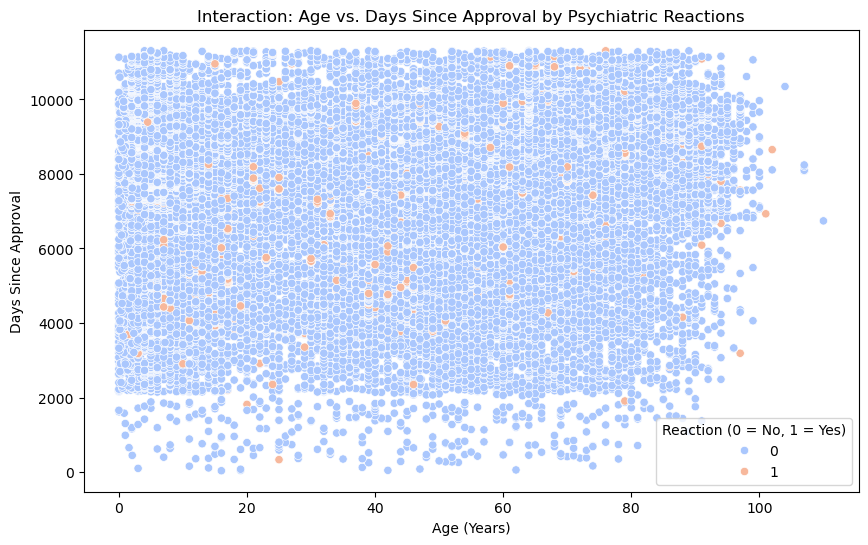

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a copy of the data with the most important features
df_investigation = X.copy()
df_investigation['psychiatric_adverse_reaction'] = y

# Add square root transformations for age and days since approval
if 'age^2' in df_investigation.columns and 'days_since_approval^2' in df_investigation.columns:
    df_investigation['age_sqrt'] = np.sqrt(df_investigation['age^2'])
    df_investigation['days_since_approval_sqrt'] = np.sqrt(df_investigation['days_since_approval^2'])

# 1. Singulair Interaction: Presence of Singulair vs. Psychiatric Adverse Reaction
if 'allergy_medication_SINGULAIR' in df_investigation.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='allergy_medication_SINGULAIR', 
        y='psychiatric_adverse_reaction', 
        data=df_investigation, 
        ci=None
    )
    plt.title("Singulair Use vs. Psychiatric Adverse Reactions")
    plt.xlabel("Singulair (0 = No, 1 = Yes)")
    plt.ylabel("Psychiatric Adverse Reaction Rate")
    plt.show()

# 2. Interaction Effect: Age vs. Days Since Approval (Colored by Reaction)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='age_sqrt', 
    y='days_since_approval_sqrt', 
    hue='psychiatric_adverse_reaction', 
    data=df_investigation, 
    palette='coolwarm'
)
plt.title("Interaction: Age vs. Days Since Approval by Psychiatric Reactions")
plt.xlabel("Age (Years)")
plt.ylabel("Days Since Approval")
plt.legend(title="Reaction (0 = No, 1 = Yes)")
plt.show()


/var/folders/vn/g0wlzfbn7_n6wh0xn1kwxsgr0000gn/T/ipykernel_46718/1899062853.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singulair_data['years_since_approval'] = dfc['days_since_approval'] // 365


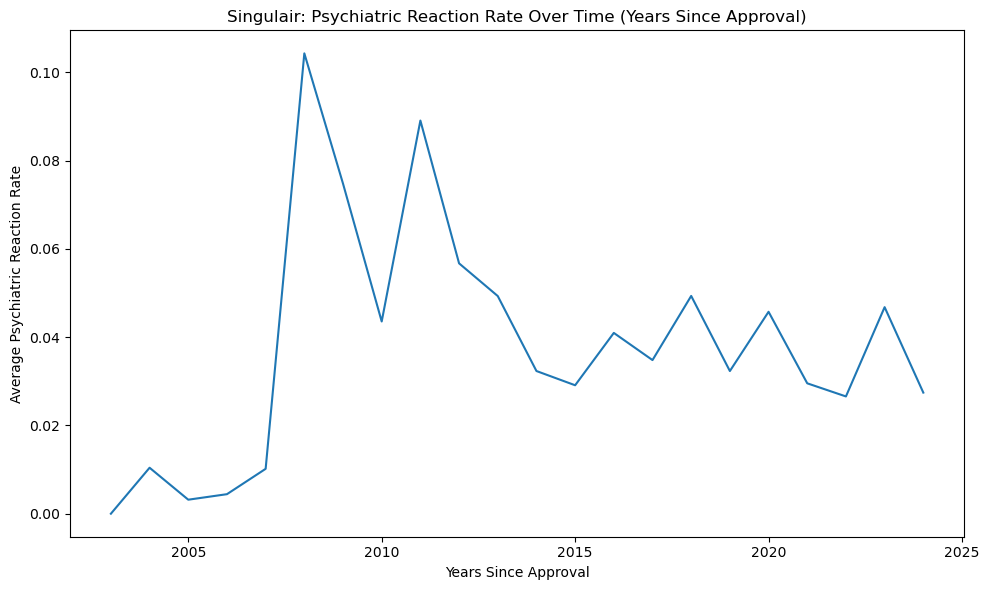

In [11]:
# Filter data for Singulair
singulair_data = df_investigation[df_investigation['allergy_medication_SINGULAIR'] == 1]

# Add a column for years since approval
singulair_data['years_since_approval'] = dfc['days_since_approval'] // 365

# Group by years since approval and calculate average psychiatric reaction rate
singulair_trend_smoothed = singulair_data.groupby('years_since_approval').psychiatric_adverse_reaction.mean().reset_index()

# Change the x-axis to represent years since approval into actual years
singulair_trend_smoothed['years_since_approval'] = singulair_trend_smoothed['years_since_approval'] + 1998

# Plot the smoothed trendline
plt.figure(figsize=(10, 6))
sns.lineplot(x='years_since_approval', y='psychiatric_adverse_reaction', data=singulair_trend_smoothed)
plt.title("Singulair: Psychiatric Reaction Rate Over Time (Years Since Approval)")
plt.xlabel("Years Since Approval")
plt.ylabel("Average Psychiatric Reaction Rate")
plt.tight_layout()
plt.show()

